In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent))

In [3]:
import os
import sys

storage_path = os.path.abspath("../storages")
llm_response_path = os.path.abspath("../process")
summarization_path = os.path.abspath("../summarization")
sys.path.append(storage_path)
sys.path.append(llm_response_path)
sys.path.append(summarization_path)

In [4]:
import pandas as pd
from evaluation import PubmedQAEvaluation

# 1. Baseline (no context)

In [5]:
medrag_processor = MedRAGPipeline()

/home/mikhail/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
evaluator = PubmedQAEvaluation(medrag_processor)
records = evaluator.evaluate('/s3/misha/data_dir/MedRAG/evaluation/df_test_sampled.csv', model_name='llama')


  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:30<00:00, 16.16it/s]


In [11]:
df_results_no_context = pd.DataFrame(records)
df_results_no_context.to_csv('/s3/misha/data_dir/MedRAG/evaluation/results/baseline_ollama.csv', index=False)

In [12]:
df_results_no_context = pd.read_csv('/s3/misha/data_dir/MedRAG/evaluation/results/baseline_ollama.csv')
df_results_no_context['binary_label'] = df_results_no_context['label'].map({'yes': 1, 'no': 0})
df_results_no_context['binary_pred'] = df_results_no_context['pred'].map({'yes': 1, 'no': 0})

In [13]:
df_results_no_context

,QUESTION,label,pred,binary_label,binary_pred
0,Is comparison of ( 68 ) Ga DOTATATE to 18F-FDG...,yes,yes,1,1
1,Do plasma phospholipids and fatty acid composi...,yes,yes,1,1
2,Is allergic sensitization enhanced in early li...,yes,yes,1,1
3,Are serum creatinine levels significantly infl...,yes,no,1,0
4,Does modification of Knee Flexion Angle have P...,yes,yes,1,1
...,...,...,...,...,...
495,Is tamoxifen effective in good prognosis patie...,no,no,0,0
496,Does periportal fibrosis without cirrhosis aff...,no,no,0,0
497,Does semen treatment with progesterone and/or ...,no,no,0,0
498,Do minor protease inhibitor mutations at basel...,no,no,0,0


In [14]:
labels_no_context = df_results_no_context['binary_label'].values
preds_no_context = df_results_no_context['binary_pred'].values

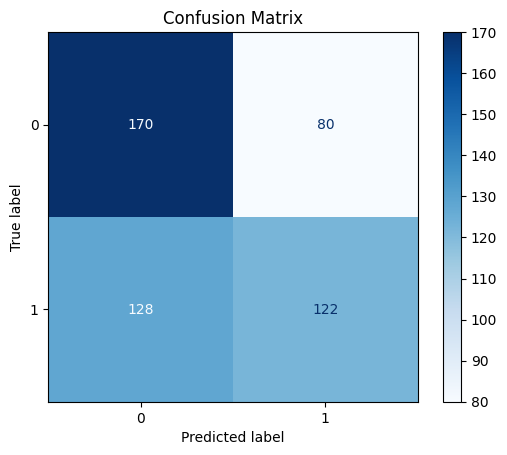

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

cm = confusion_matrix(labels_no_context, preds_no_context)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(labels_no_context))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

print('accuracy', accuracy_score(labels_no_context, preds_no_context))
print('precision', precision_score(labels_no_context, preds_no_context))
print('recall', recall_score(labels_no_context, preds_no_context))
print('f1', f1_score(labels_no_context, preds_no_context))

accuracy 0.584
precision 0.6039603960396039
recall 0.488
f1 0.5398230088495575


# 2. QA with context

In [ ]:
from pipeline import MedRAGPipeline
medrag_processor = MedRAGPipeline()

evaluator = PubmedQAEvaluation(medrag_processor)
records = evaluator.evaluate('/s3/misha/data_dir/MedRAG/evaluation/df_test_sampled.csv', is_with_context=True, model_name='llama')

100%|██████████| 500/500 [09:21<00:00,  1.12s/it]


In [7]:
df_results_with_context = pd.DataFrame(records)
df_results_with_context.to_csv('/s3/misha/data_dir/MedRAG/evaluation/results/medrag_ollama.csv', index=False)

In [8]:
df_results_with_context = pd.read_csv('/s3/misha/data_dir/MedRAG/evaluation/results/medrag_ollama.csv')
df_results_with_context['binary_label'] = df_results_with_context['label'].map({'yes': 1, 'no': 0})
df_results_with_context['binary_pred'] = df_results_with_context['pred'].map({'yes': 1, 'no': 0})

In [9]:
labels_with_context = df_results_with_context['binary_label'].values
preds_with_context = df_results_with_context['binary_pred'].values

In [14]:
df_results_with_context['pred'].value_counts()

pred
no     442
yes     58
Name: count, dtype: int64

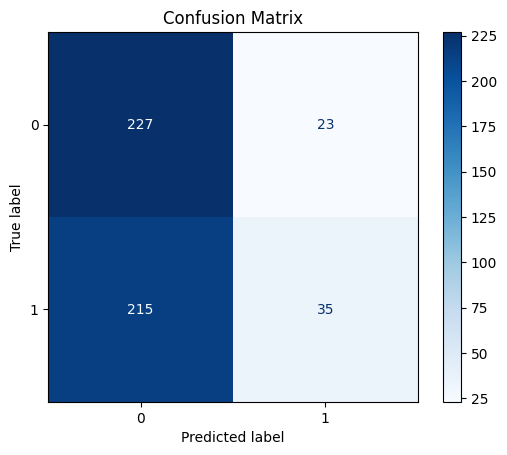

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

cm = confusion_matrix(labels_with_context, preds_with_context)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(labels_with_context))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print('accuracy', accuracy_score(labels_with_context, preds_with_context))
print('precision', precision_score(labels_with_context, preds_with_context))
print('recall', recall_score(labels_with_context, preds_with_context))
print('f1', f1_score(labels_with_context, preds_with_context))

accuracy 0.524
precision 0.603448275862069
recall 0.14
f1 0.22727272727272727


# 3. Let's check if ollama can perform well while using pre-defined context

In [6]:
df_test = pd.read_csv('/s3/misha/data_dir/MedRAG/evaluation/df_test_sampled.csv')
df_test['CONTEXTS'] = df_test['CONTEXTS'].apply(eval)

In [30]:
df_test.head(2)

,QUESTION,CONTEXTS,LABELS,LONG_ANSWER,MESHES,final_decision
0,Is comparison of ( 68 ) Ga DOTATATE to 18F-FDG...,[The evaluation of the remaining pituitary tis...,"['OBJECTIVE', 'METHODS', 'RESULTS']",Different degree of uptake of Ga DOTATATE and ...,"['Adenoma', 'Adult', 'Cicatrix', 'Female', 'Fl...",yes
1,Do plasma phospholipids and fatty acid composi...,[There is growing evidence that nonalcoholic f...,"['BACKGROUND', 'OBJECTIVE', 'METHODS', 'RESULTS']",The present study demonstrates that there is a...,"['Adult', 'Cross-Sectional Studies', 'Fatty Ac...",yes


In [29]:
len(df_test.loc[1, 'CONTEXTS'])

4

In [31]:
from process import ollama_response_with_context
from tqdm import tqdm

labels = []
preds = []

for index, value in tqdm(df_test.iterrows(), total=len(df_test)):
    question = value['QUESTION']
    combined_string = " ".join(value['CONTEXTS'])

    response = ollama_response_with_context(question, combined_string)

    labels.append(value['final_decision'])
    preds.append(response)

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [01:43<00:00,  4.84it/s]


In [35]:
for i in range(len(preds)):
    preds[i] = preds[i].replace('.', '')

In [36]:
np.unique(np.array(labels), return_counts=True)

(array(['no', 'yes'], dtype='<U3'), array([250, 250]))

In [37]:
np.unique(np.array(preds), return_counts=True)

(array(['no', 'yes'], dtype='<U3'), array([266, 234]))

In [38]:
binary_labels = [1 if item == "yes" else 0 for item in labels]
binary_preds = [1 if item == "yes" else 0 for item in preds]

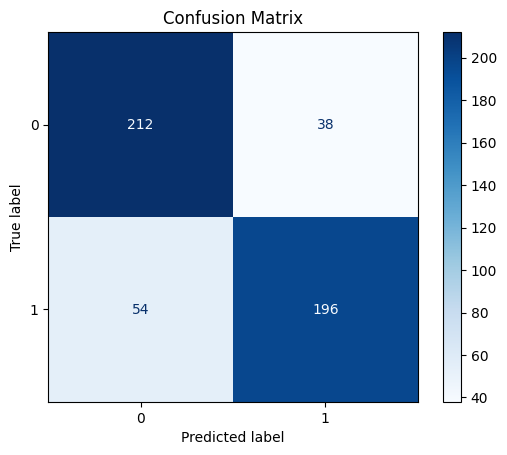

In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

cm = confusion_matrix(binary_labels, binary_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(binary_labels))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [40]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print('accuracy', accuracy_score(binary_labels, binary_preds))
print('precision', precision_score(binary_labels, binary_preds))
print('recall', recall_score(binary_labels, binary_preds))
print('f1', f1_score(binary_labels, binary_preds))

accuracy 0.816
precision 0.8376068376068376
recall 0.784
f1 0.8099173553719008


# 4. Ollama + articles extracted from pubmed using keyword search

In [5]:
df_test = pd.read_csv('/s3/misha/data_dir/MedRAG/evaluation/df_test_sampled.csv')
df_test['CONTEXTS'] = df_test['CONTEXTS'].apply(eval)

In [6]:
df_test['QUESTION'][0]

'Is comparison of ( 68 ) Ga DOTATATE to 18F-FDG uptake useful in the differentiation of residual or recurrent pituitary adenoma from the remaining pituitary tissue after transsphenoidal adenomectomy?'

In [ ]:
from process.articles_extraction import SummarizedArticlesExtractor
from process import ollama_response_with_context
from tqdm import tqdm

labels = []
preds = []

summarized_articles_extractor = SummarizedArticlesExtractor()

for index, value in tqdm(df_test.iterrows(), total=len(df_test)):
    question = value['QUESTION']
    context = summarized_articles_extractor.process(question, task='qa')
    response = ollama_response_with_context(question, context)

    labels.append(value['final_decision'])
    preds.append(response)

    print(f'label: {value["final_decision"]}, pred: {response}')

In [10]:
df_test['QUESTION'][6]

'Does platelet-rich plasma increase transforming growth factor-beta1 expression at graft-host interface following autologous osteochondral transplantation in a rabbit model?'